In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing and loading of data

In [ ]:
#ls drive/MyDrive/reside/archive/clear_images drive/MyDrive/reside/archive/haze  

In [ ]:
# function to load the image in the form of tensors.

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    img = img / 255.0
    return img

In [ ]:
# function to get the path of individual image.

def data_path(orig_img_path, hazy_img_path):
    
    train_img = []
    val_img = []
    
    orig_img = glob.glob(orig_img_path + '/*.jpg')
    n = len(orig_img)
    random.shuffle(orig_img)
    train_keys = orig_img[:int(0.9*n)]        #90% data for train, 10% for test
    val_keys = orig_img[int(0.9*n):]
    
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
        
    hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    for img in hazy_img:
        img_name = img.split('/')[-1]
        orig_path = orig_img_path + '/' + img_name.split('_')[0] + '.jpg'
        if (split_dict[orig_path] == 'train'):
            train_img.append([img, orig_path])
        else:
            val_img.append([img, orig_path])
            
    return train_img, val_img

In [ ]:
# function to load tensor image data in batches.

def dataloader(train_data, val_data, batch_size):
    
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [ ]:
# function to display output.

def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()

# Network Function

In [ ]:
def dehaze_net():
    
    inputs = tf.keras.Input(shape = [550,413,3])
    conv1 = Conv2D(input_shape = (550, 413, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(inputs)
    conv2 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(conv1)
    concat1 = tf.concat([conv1,conv2], axis = -1)
    
    conv3 = Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat1)
    concat2 = tf.concat([conv2,conv3], axis = -1)
    
    conv4 = Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4], axis = -1)
    
    conv5 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat3)
    K = conv5
    output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
    
    #model = Model(inputs = x, outputs = output)
    
    return Model(inputs = inputs, outputs = 

output)



In [ ]:
# Hyperparameters
epochs = 10
batch_size = 8
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

train_data, val_data = data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze')
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net =dehaze_net()

train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

In [ ]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                loss = mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [==]  -  Training Loss: 0.1999

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


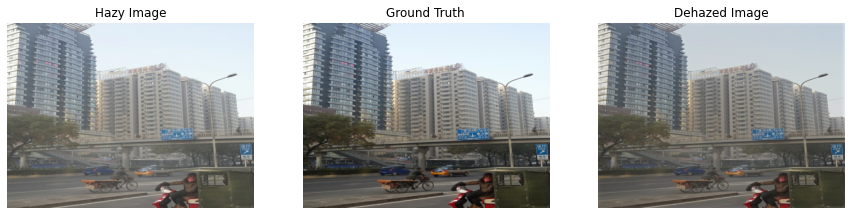

  -  Validation Loss: 0.0084  -   Time taken: 361.42s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 1 [==]  -  Training Loss: 0.0143

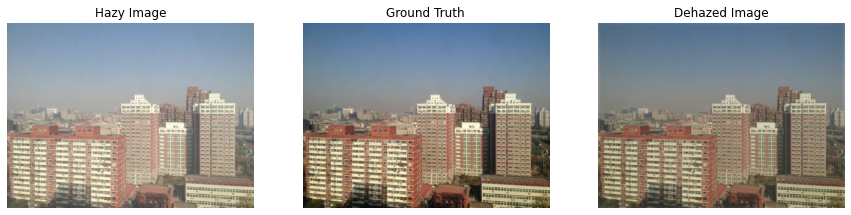

  -  Validation Loss: 0.0104  -   Time taken: 173.16s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 2 [==]  -  Training Loss: 0.0135

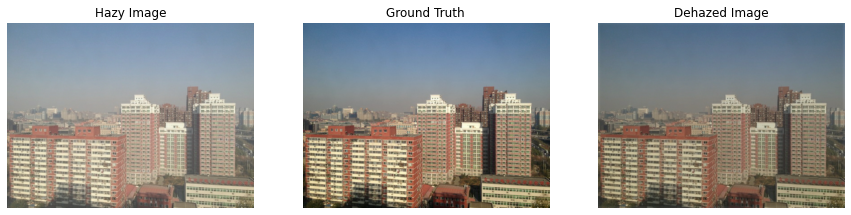

  -  Validation Loss: 0.0102  -   Time taken: 172.95s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 3 [==]  -  Training Loss: 0.0129

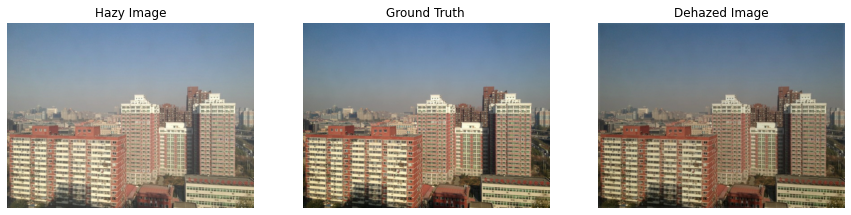

  -  Validation Loss: 0.0096  -   Time taken: 173.06s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 4 [==]  -  Training Loss: 0.0126

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


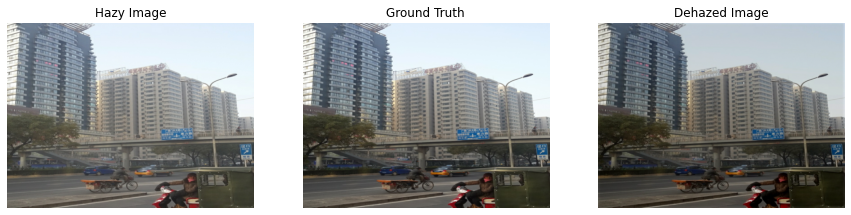

  -  Validation Loss: 0.0090  -   Time taken: 172.96s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 5 [==]  -  Training Loss: 0.0120

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


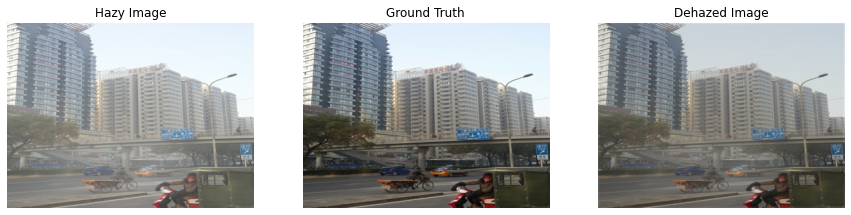

  -  Validation Loss: 0.0087  -   Time taken: 173.20s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 6 [==]  -  Training Loss: 0.0099

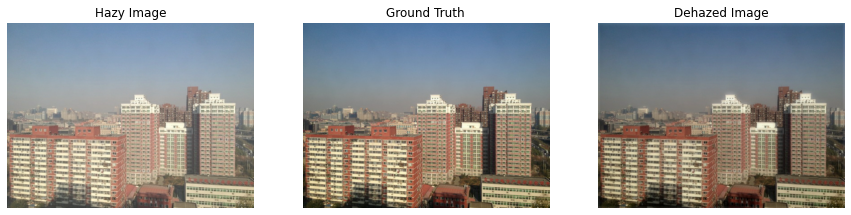

  -  Validation Loss: 0.0088  -   Time taken: 173.15s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 7 [==]  -  Training Loss: 0.0084

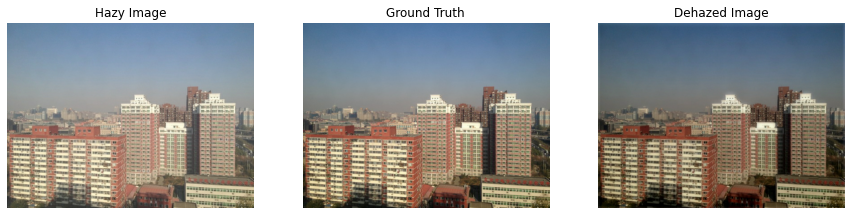

  -  Validation Loss: 0.0104  -   Time taken: 173.28s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 8 [==]  -  Training Loss: 0.0081

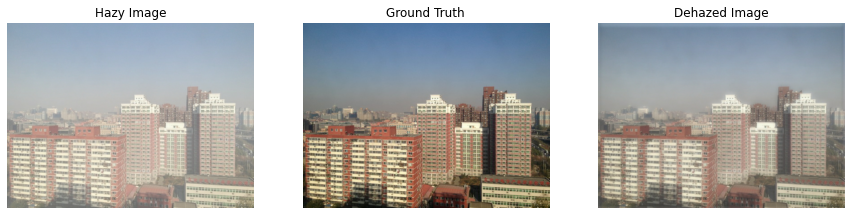

  -  Validation Loss: 0.0076  -   Time taken: 173.16s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 9 [==]  -  Training Loss: 0.0078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


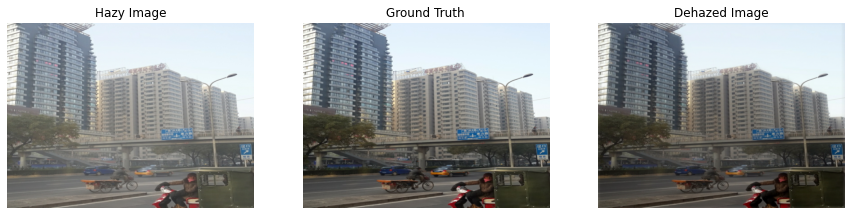

  -  Validation Loss: 0.0084  -   Time taken: 173.16s
INFO:tensorflow:Assets written to: trained_model/assets
CPU times: user 9min 45s, sys: 5min, total: 14min 46s
Wall time: 32min 39s


In [ ]:
%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)

In [ ]:
def evaluate(net, test_img_path):
    
    test_img = glob.glob(test_img_path + '/*.jpg')
    random.shuffle(test_img)
    
    for img in test_img:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_jpeg(img, channels = 3)
        
        if img.shape[1] > img.shape[0]:
            img = tf.image.resize(img, size = (1080, 1920), antialias = True)
        if img.shape[1] < img.shape[0]:
            img = tf.image.resize(img, size = (1920, 1080), antialias = True)
        
        img = img / 255.0
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze = net(img, training = False)
        
        plt.figure(figsize = (80, 80))
        
        display_list = [img[0], dehaze[0]]       #make the first dimension zero
        title = ['Hazy Image', 'Dehazed Image']

        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.title(title[i], fontsize = 65, y = 1.045)
            plt.imshow(display_list[i])
            plt.axis('off')
        
        plt.show()

In [ ]:
test_net = tf.keras.models.load_model('trained_model', compile = False)
evaluate(test_net, '../input/hazy-test-images')